# Interaction with MSNoise and plotting dv/v

## Importing modules and libraries

In [23]:
#import msnoise.api as ms
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import csv
import datetime
import scipy

## Interacting with MSNoise

In [ ]:
# Connecting to the database of MSNoise

path_ini = 'D:\\MEMOIRE\\MSNoise\\master\\db.ini'
database = ms.connect(inifile=path_ini)

In [ ]:
NET = ms.get_networks(database)
STA = ['BJK','DJK','HUS','VOT','JOK','KSK','URH','GRF','KVI']

In [ ]:
for sta in STA :
    ms.mark_data_availability(database, 'VI', sta, 'A')
ms.is_next_job(database, flag='T', jobtype='CC')

In [3]:
#ms.get_filters(database, all=True)

In [ ]:
#ms.update_filter(database,ref=2,low=1.0,high=2.0,mwcs_low=1.0,mwcs_high=2.0, mwcs_wlen=120, 
                     mwcs_step=60 , rms_threshold=0, used=True)

## dvv plotting

### Specify the root of dtt files and pair station names

In [38]:
component = 'ZZ'
mwlength = '015'
filterID = '07'
frqlen = '0.5-1.0Hz'
# Root of the dtt files to plot
root = 'D:/MEMOIRE/MsNoise/ablation/DTT/%s/%s_DAYS/%s/' %(filterID, mwlength, component)
folder = os.listdir(root)
# Root of the stations pairs names
rootpair = 'D:/MEMOIRE/MSNoise/ablation/MWCS/%s/%s_DAYS/%s/' %(filterID, mwlength, component)
pair_name = os.listdir(rootpair)

### Example of a dtt files

In [39]:
df = pd.read_csv(root+folder[0])

In [40]:
df

,Date,Pairs,M,EM,A,EA,M0,EM0
0,2018-01-01,VI_BJK_VI_DJK,-0.001306,0.001253,0.074952,0.021103,0.002791,0.000840
1,2018-01-01,VI_BJK_VI_GRF,0.000938,0.000777,-0.032852,0.009962,0.000799,0.001204
2,2018-01-01,VI_BJK_VI_URH,0.000157,0.000833,0.060827,0.015363,0.001922,0.001707
3,2018-01-01,VI_DJK_VI_GRF,0.001251,0.000544,-0.049011,0.010011,0.001888,0.001371
4,2018-01-01,VI_GRF_VI_URH,0.000950,0.001384,0.016298,0.022445,0.001055,0.001310
5,2018-01-01,ALL,0.000778,0.000918,-0.020686,0.018620,0.000316,0.000830


### Extracting the data from each dtt files

In [41]:
pair = []
M0 = []
date = []
NY = []
idxNY = []

ALLM = []
ALLEM = []

frt = '%Y-%m-%d'

X = list(range(len(folder)))
Y = list(range(len(pair_name)))

xv, yv = np.meshgrid(X, Y)
line = 0

m = np.zeros(xv.shape)+999 #creating a empty initial list of 999
#print(m)

for file in folder :
    df = pd.read_csv(root+file)
    tpair = df['Pairs'].tolist() # extrating pairs
    tdate = df['Date'].tolist() #extraction dates
    tM = df['M'].tolist() #extracting slope
    tEM = df['EM'].tolist()
    if line == 0 :
        sttdate = datetime.datetime.strptime(tdate[0],frt)
    currdate = datetime.datetime.strptime(tdate[0],frt)
    date.append(currdate)
    posdate = currdate - sttdate
    posdate = int(posdate.days) # determine the date position
    if currdate.day == 1 and currdate.month == 1 :
        NY.append(currdate)
        idxNY.append(posdate)
    #print(int(posdate.days))
    line += 1
    
    for ti in range(len(tpair)) :
        if tpair[ti] != 'ALL' :
            idx = pair_name.index(tpair[ti])
            m[idx][posdate] = float(tM[ti])
        if tpair[ti] == 'ALL' :
            ALLM.append(float(tM[ti]))
            ALLEM.append(float(tEM[ti]))
    m = np.where(m == 999, np.nan, m)

### Plotting mean curve with error

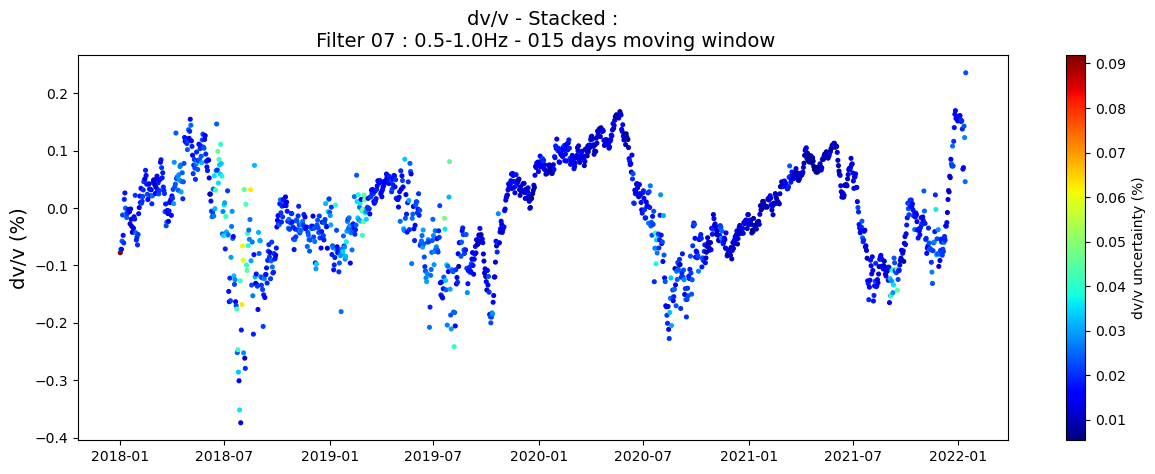

In [42]:
fig = plt.figure(figsize=(15,5))
plt.scatter(date,np.array(ALLM)*-100, c=np.array(ALLEM)*100, cmap='jet',s=7)
plt.ylabel('dv/v (%)', fontsize=14)
plt.colorbar(label='dv/v uncertainty (%)')
plt.title('dv/v - Stacked :\n Filter %s : %s - %s days moving window' %(filterID, frqlen, mwlength ),
          fontsize='14')
plt.savefig('./plot_interfero/dvv-ALL-f%s.png' %(filterID), bbox_inches='tight')

## Plotting FFT

(-0.05, 0.05)

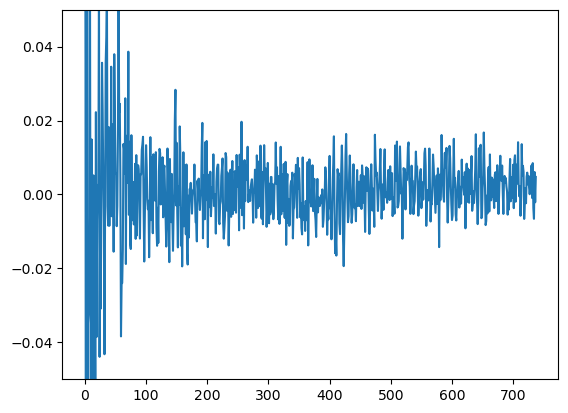

In [73]:
Y = scipy.fft.rfftn(np.array(ALLM))
plt.plot(Y)
#plt.xlim(50,600)
plt.ylim(-0.05,0.05)

### Plotting the data with pcolormesh

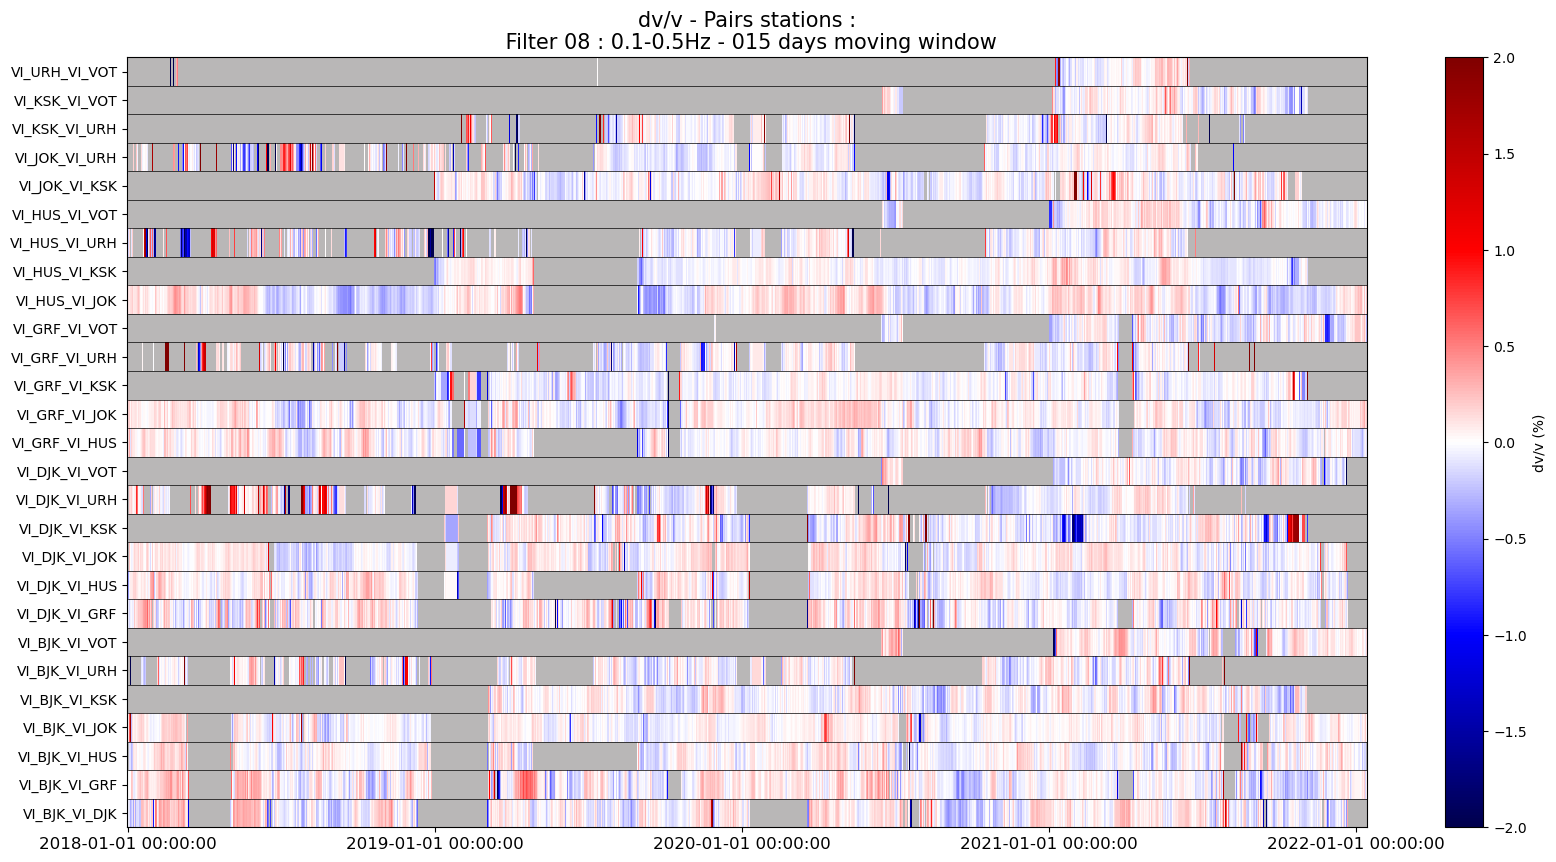

In [39]:
from matplotlib import colors

plt.figure(figsize=(20,10))
ax = plt.axes()
ax.set_facecolor("#B9B7B7")
norm = colors.Normalize(vmin=-2,vmax=2)
#norm = colors.CenteredNorm()
plt.pcolormesh(xv,yv,m*-100, norm=norm, cmap='seismic')
for i in range(len(pair_name)) :
    temp = np.array([X[0],X[-1]])
    plt.plot(temp, [i-.5,i-.5], c='black',linewidth = .5)
plt.yticks(ticks=Y,labels=pair_name)
plt.xticks(ticks=idxNY,labels=NY, fontsize='12')
plt.title('dv/v - Pairs stations :\n Filter %s : %s - %s days moving window' %(filterID, frqlen, mwlength ),
          fontsize='15')
plt.colorbar(label='dv/v (%)')
plt.savefig('./plot_interfero/dvv-f%s-%s_%sd.png' %(filterID, frqlen, mwlength ), bbox_inches='tight')
plt.show()